In [ ]:
!pip install utils

In [ ]:
import helper
import pandas as pd
from utils import *

import time
import numpy as np
import math
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torch import nn

from IPython.display import Image

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/ECTA 2023 Dataset2.csv')
#df = df.drop(['Date' ,'Unnamed: 0'], axis=1)
df

In [ ]:
target = "Temperature"

In [ ]:
features = ["Year","Quarter","Month","Week_Of_Year","Day_of_Year","Day_Of_Week","Stat_Hol","Hour_of_Day","Relative Humidity","Wind Speed","Visibility","Pressure","Wind_Chill","Dewpoint Temp"]
features

In [ ]:
size = int(len(df) * 0.67)
df_train = df.loc[:size].copy()
df_test = df.loc[size:].copy()

In [ ]:
target_mean = df_train[target].mean()
target_stdev = df_train[target].std()

for c in df_train.columns:
    mean = df_train[c].mean()
    stdev = df_train[c].std()

    df_train[c] = (df_train[c] - mean) / stdev
    df_test[c] = (df_test[c] - mean) / stdev

In [ ]:
!pip install pennylane

In [ ]:
from Factory import SequenceDataset

In [ ]:
torch.manual_seed(101)

batch_size = 250
sequence_length = 3

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([250, 3, 14])
Target shape: torch.Size([250])


In [ ]:
from Factory import QShallowRegressionLSTM

In [ ]:
learning_rate = 0.05
num_hidden_units = 16

Qmodel = QShallowRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units, n_qubits=4)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adagrad(Qmodel.parameters(), lr=learning_rate)

weight_shapes = (n_qlayers, n_vrotations, n_qubits) = (1, 3, 4)


In [ ]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()

    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")
    return avg_loss

def test_model(data_loader, model, loss_function):

    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")
    return avg_loss

In [ ]:
quantum_loss_train = []
quantum_loss_test = []
print("Untrained test\n--------")
start = time.time()
test_loss = test_model(test_loader, Qmodel, loss_function)
end = time.time()
print("Execution time", end - start)
quantum_loss_test.append(test_loss)

for ix_epoch in range(3):
    print(f"Epoch {ix_epoch}\n---------")
    start = time.time()
    train_loss = train_model(train_loader, Qmodel, loss_function, optimizer=optimizer)
    test_loss = test_model(test_loader, Qmodel, loss_function)
    end = time.time()
    print("Execution time", end - start)
    quantum_loss_train.append(train_loss)
    quantum_loss_test.append(test_loss)

Untrained test
--------
Test loss: 0.966478040383663
Execution time 62.131924867630005
Epoch 0
---------
Train loss: 0.042387959626449354
Test loss: 0.004692280972903973
Execution time 240.99168586730957
Epoch 1
---------
Train loss: 0.0038169168617259927
Test loss: 0.0035959708088739717
Execution time 244.2266926765442
Epoch 2
---------
Train loss: 0.0028983412474990755
Test loss: 0.0033334770373585343
Execution time 244.94819402694702


In [ ]:
def predict(data_loader, model):
    """Just like `test_loop` function but keep track of the outputs instead of the loss
    function.
    """
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)

    return output

In [ ]:
train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

ystar_col_Q = "Model forecast"
df_train[ystar_col_Q] = predict(train_eval_loader, Qmodel).numpy()
df_test[ystar_col_Q] = predict(test_loader, Qmodel).numpy()

df_out_Q = pd.concat((df_train, df_test))[[target, ystar_col_Q]]

for c in df_out_Q.columns:
    df_out_Q[c] = df_out_Q[c] * target_stdev + target_mean

print(df_out_Q)

       Temperature  Model forecast
0             -9.3       -9.496402
1             -9.3       -9.586778
2             -9.6       -9.842805
3             -9.8       -9.984473
4             -9.7      -10.060019
...            ...             ...
96427          1.6        1.239506
96428          1.1        0.603025
96429          1.0        0.578898
96430          0.9        0.488645
96431          0.6        0.209046

[96433 rows x 2 columns]


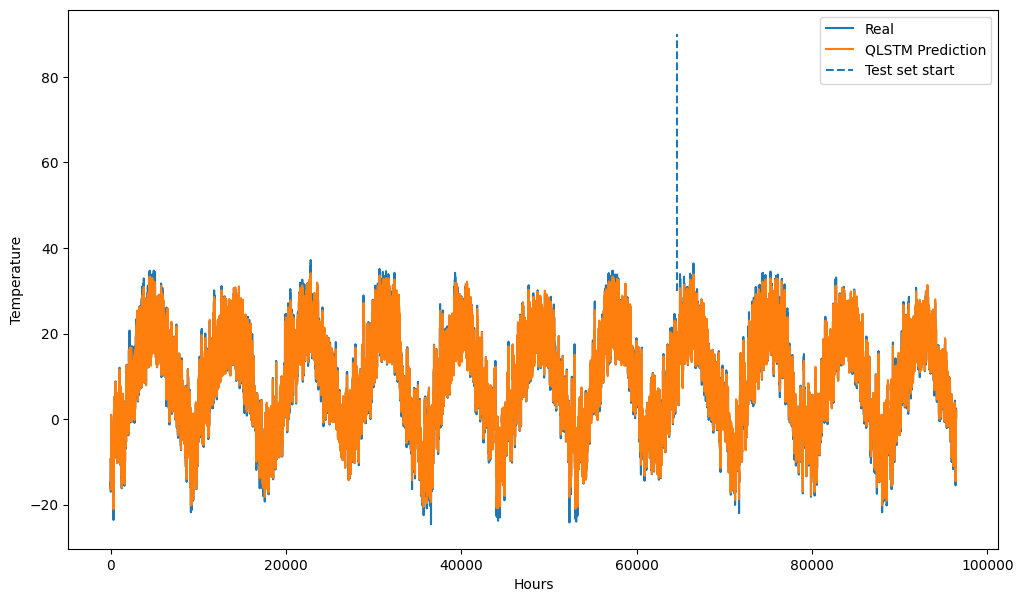

In [ ]:
plt.figure(figsize=(12, 7))
plt.plot(range(96433), df_out_Q["Temperature"], label = "Real")
plt.plot(range(96433), df_out_Q["Model forecast"], label = "QLSTM Prediction")
plt.ylabel('Temperature')
plt.xlabel('Hours')
plt.vlines(size, ymin = 30, ymax = 90, label = "Test set start", linestyles = "dashed")
plt.legend()
plt.show()

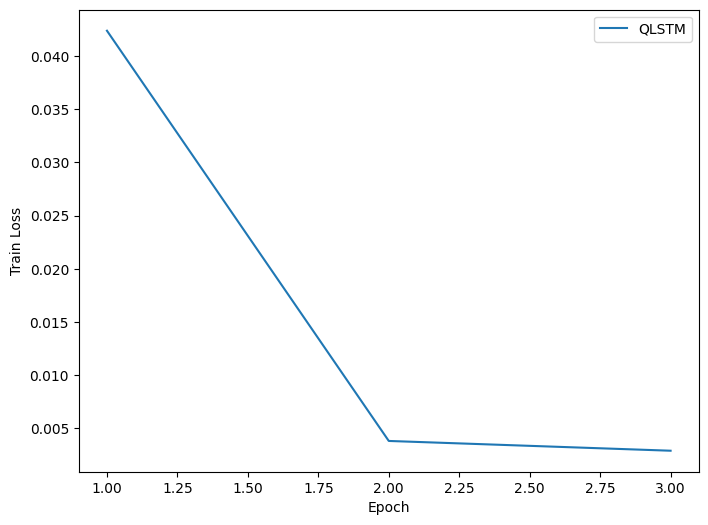

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(range(1,4), quantum_loss_train, label = "QLSTM")
plt.ylabel('Train Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()